# Ce projet fonctionne avec les versions des package suivants:

- matplotlib==3.9.0
- pandas==2.2.2
- seaborn==0.13.2
- missingno==0.5.2
- scikit-learn==1.5.1

## The Data
This is a dataset of food products listing the ingredients and nutritional facts of more than 300,000 foods from over 150 countries in the world. The data is meant to be free to the public to help users decode food labels, and make better food choices in general. The dataset contains more than 300,000 rows over 163 columns. However, as we will see there are a lot of missing or obviously incorrect values.<br/>
Generalities:

- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product

Depuis le 26 juin 2024, la méthode de calcul du Nutri-Score a été mise à jour on peu en trouver les détails dans ce document:
- https://www.santepubliquefrance.fr/content/download/150262/file/FAQ-updatedAlgo-FR_20231222.pdf

En utilisant ce document, on peut selectionner les colonnes à conserver les plus pertinente.

In [1505]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.api as sm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import tkinter as tk
from tkinter import filedialog

import missingno as msno
import ipywidgets as widgets
from wordcloud import WordCloud
from IPython.display import display, HTML,clear_output

# Nettoyer et Filtrer les Features et Produits

## 1.1. Collecter et Préparer les Données Brutes
### 1. Charger les données dans un DataFrame Pandas

In [1509]:
def project_init():
    global original_data, original_selected
    display(HTML("<h1 style='color: navy'>Open Food Facts</h1>"))
    print('Initialisation du projet...', end='\r')
    filepath ='datas/openfoodfacts.csv'
    target ='nutrition_grade_fr'
    original_selected=['energy_100g','saturated-fat_100g','sugars_100g','salt_100g','proteins_100g','fiber_100g']
    # selected = ['energy_100g','salt_100g','alcohol_100g','cocoa_100g','potassium_100g','nutrition_grade_fr']
    original_data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
    print(' '*len('Initialisation du projet...'), end='\r')
    print('Projet chargé')
    return filepath, target, selected, original_data

In [1511]:
filepath, target, selected, original_data= project_init()

Projet chargé              


In [1512]:
def select_file():
    print("charger le nouveau fichier")
    root =tk.Tk()
    root.withdraw()

    filepath = filedialog.askopenfilename(
        title="Choisissez votre fichier csv",
        filetypes=(("Fichiers CSV","*.csv"), ("Tous les fichiers","*.*"))
    )
    print(' '*len("charger le nouveau fichier"),end='\r')
    print("chargement en cours...")
    root.destroy()

    if filepath:
        try:
            original_data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
            print(' '*len("chargement en cours..."),end='\r')
            print(f"Fichier chargé avec succès depuis le chemin: {filepath}")
            return original_data
        except Exeption as e:
            print("Erreur lors du chargement du fichier:",e)
    else:
        print("Aucun fichier sélectionné.")

In [1515]:
def split_features(data):
    quantitative_features = data.select_dtypes(include=['float64','int64'])
    qualitative_features = data.select_dtypes(include=['object'])
    return quantitative_features,qualitative_features

In [1517]:
def columns_to_keep(data, selected, target):
    columns_list=['code','product_name']
    selected = selected + columns_list
    # print(target)
    # print(selected)
    if target not in selected:
        selected.append(target)

    filtered_data = data[selected]
    # print(filtered_data.columns)
    return filtered_data

In [1519]:
def clean_row_without_target(filtered_data,target):
    # print(f'targte==> {target}')
    # print(f'filtered_data==> {filtered_data.columns}')
    data.shape
    print(f"Nombre de lignes avant suppression : {data.shape[0]}")

    display(HTML("<h4>suppression des lignes sans cible...</h4>"))

    data_cleaned = filtered_data.dropna(subset=[target])
    # print(' '*len('suppression des lignes sans cible...'), end='\r')
    print('✅ Lignes sans cible supprimées')
    print(f"Nombre de lignes après suppression des ligne sans la cible '{target}' : {data_cleaned.shape[0]}")
    return data_cleaned

In [1521]:
def nan_detection(data):
    display(HTML("<h4>Nombre de valeur NaN des features selectionnées:</h4>"))

    nan_counts= data[original_selected].isna().sum()
    # print(nan_counts)
    return nan_counts

In [1523]:
def nan_inputation(data):
    exeption_col = ['energy_100g']
    # Sélectionner les colonnes se terminant par '_100g'
    columns_to_modify = [col for col in data.filter(regex='_100g').columns if col not in exeption_col]
    
    # Créer une copie des données
    nan_inputation = data.copy()
    
    # Remplacer les valeurs supérieures à 100 ou inférieures à 0 par NaN uniquement dans les colonnes sélectionnées
    nan_inputation.loc[:, columns_to_modify] = nan_inputation.loc[:, columns_to_modify].apply(
        lambda x: np.where((x > 100) | (x < 0), np.nan, x)
    )
    
    return nan_inputation

In [1537]:
def find_best_k(data_cleaned,original_selected):
    
    x = data_cleaned[original_selected]
    
    x_train, x_valid = train_test_split(x.dropna(), test_size=0.2, random_state=42)
    
    # Introduire des NaN dans l'ensemble de validation pour simuler les valeurs manquantes
    x_valid_with_nan = x_valid.copy()
    
    missing_mask = np.random.rand(*x_valid_with_nan.shape) < 0.1  # Par exemple, 10% de valeurs manquantes ajoutées

    x_valid_with_nan[missing_mask] = np.nan

    k_range=range(1,10)
    errors=[]

    for k in k_range:
        imputer = KNNImputer(n_neighbors=k)
        x_valid_imputer = imputer.fit_transform(x_valid_with_nan)

        mse=[]
        for i in range(x_valid.shape[1]):
            # Calcul l'erreur de l'imputation (par exemple ,l'erreur quadratique moyenne )
            mse.append(mean_squared_error(x_valid.iloc[:,i][missing_mask[:,i]],
                                          x_valid_imputer[:,i][missing_mask[:,i]]))
        errors.append(np.mean(mse))

    # Trouver le k avec la plus petite erreur
    best_k =k_range[np.argmin(errors)]

    print(f"Le meilleur k est {best_k} avec une erreur quadratique moyenne de {min(errors):.4f}")

    plt.plot(k_range, errors)
    plt.xlabel('Nombre de voisins k')
    plt.ylabel('Erreur quadratique moyenne')
    plt.title('Erreur en fonction du nombre de voisins k')
    plt.show()
        


In [1539]:
def my_app():
    data = original_data.copy()
    selected = original_selected
    # filepath, target, selected, data= project_init()
    shape = data.shape
    print(f'Shape :\nLe jeu de données contient {shape[0]} lignes et {shape[1]} colonnes\n')
    print(f'Info :\nLes information sur les colonnes du jeu de données sont les suivantes:\n')
    # data.info()
    print(f'\nDescribe :\nInformation sur les différentes colonnes du jeu de données :\n')
    # print(data.describe())
    
    quantitative_features,qualitative_features = split_features(data)
    
    filtered_data = columns_to_keep(data,selected,target)
    
    # print(selected)
    data_cleaned=clean_row_without_target(filtered_data,target)
    nan_detection(data_cleaned)
    
    data_cleaned=nan_inputation(data_cleaned)
    
    nan_detection(data_cleaned)
    # data_cleaned.head()
    find_best_k(data_cleaned,selected)
    # return data_cleaned

Shape :
Le jeu de données contient 320772 lignes et 162 colonnes

Info :
Les information sur les colonnes du jeu de données sont les suivantes:


Describe :
Information sur les différentes colonnes du jeu de données :

Nombre de lignes avant suppression : 320772


✅ Lignes sans cible supprimées
Nombre de lignes après suppression des ligne sans la cible 'nutrition_grade_fr' : 221210


Le meilleur k est 9 avec une erreur quadratique moyenne de 58997.1363


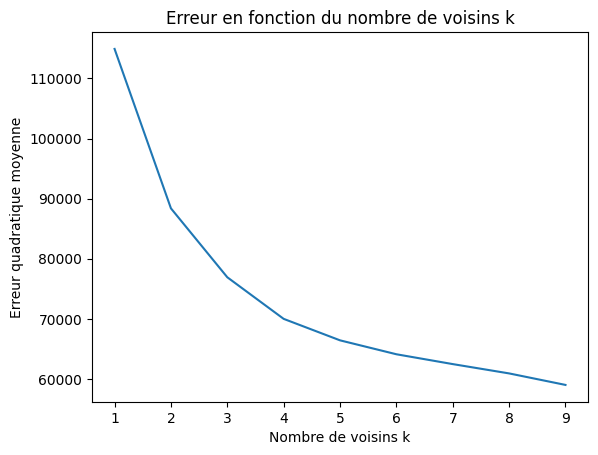

In [1541]:
my_app()